In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [4]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1 = -0.4;
k2 = 0.0
k = 0.0
tspan = (0.0, 100000.0)

(0.0, 100000.0)

In [5]:
k_space = range(-0.5, 0.5, length = 1000)
length(k_space)

1000

In [6]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)

int (generic function with 1 method)

In [7]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, 0, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
  0.0
  0.0

In [8]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k, 0]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: -0.5
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.5, 0.0]
Spectrum: [0.013180451504345651, 1.942360103782407e-5, -0.009086595022097762, -0.03414953517696495, -6.107681950395162, -12.757943890158877]
Last point: [-0.779816441945346, -2.3308282401917113, 3.9224715321127768, -0.9675498506709538, -3.888476872085456, 3.8072936259681076]
x_sum before truncate length: 1596151
x_sum after truncate length: 798077
>>>>>>>>>>>>>>>

Initial condition: [-0.779816441945346, -2.3308282401917113, 3.9224715321127768, -0.9675498506709538, -3.888476872085456, 3.8072936259681076]
index: 2
k: -0.498998998998999
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.498998998998999, 0.0]
Spectrum: [0.013172000678741214, 5.20547136388859e-6, -0.009477791821634775, -0.03375144938035165, -6.1079891306262635, -12.760362912543485]
Last point: [-0.6983364150328789, -2.310692459483772, 3.349468117849986, -0.9762228271269986, -3.7

Spectrum: [0.013420829367955533, 3.402713381195133e-5, -0.009924002856261521, -0.03233187911173102, -6.115112283765477, -12.728707008633181]
Last point: [-1.4307617661724128, -8.594053417870768, 3.936350195245608, 0.2152548916170591, -5.648987140436113, 3.704219898279406]
x_sum before truncate length: 1594452
x_sum after truncate length: 797227
>>>>>>>>>>>>>>>

Initial condition: [-1.4307617661724128, -8.594053417870768, 3.936350195245608, 0.2152548916170591, -5.648987140436113, 3.704219898279406]
index: 15
k: -0.48598598598598597
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.48598598598598597, 0.0]
Spectrum: [0.012958174044918712, 6.049071967315881e-6, -0.008881651800162739, -0.03405386612621396, -6.112892312622664, -12.73342604318495]
Last point: [-1.4241467153468355, -9.172576338706468, 3.7955704601829723, -0.9019275398733378, -3.2269294367177688, 3.926745840444745]
x_sum before truncate length: 1591986
x_sum after truncate length: 795994
>>>>>>>>>>>>>>>

Initial cond

Last point: [-1.3478193556371125, -7.982908545614341, 3.91921478285223, -0.8224441479148644, -2.8449591806058154, 3.676479943226636]
x_sum before truncate length: 1590041
x_sum after truncate length: 795022
>>>>>>>>>>>>>>>

Initial condition: [-1.3478193556371125, -7.982908545614341, 3.91921478285223, -0.8224441479148644, -2.8449591806058154, 3.676479943226636]
index: 28
k: -0.47297297297297297
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.47297297297297297, 0.0]
Spectrum: [0.013720864599520016, 2.0379340854692293e-5, -0.009513636374576999, -0.032203757442263115, -6.127910178917612, -12.664459332689379]
Last point: [-0.42062634463610554, -0.4297848839054437, 4.025482109761337, -0.9495173093329659, -3.6725716882452573, 3.6787673269308434]
x_sum before truncate length: 1577961
x_sum after truncate length: 788982
>>>>>>>>>>>>>>>

Initial condition: [-0.42062634463610554, -0.4297848839054437, 4.025482109761337, -0.9495173093329659, -3.6725716882452573, 3.6787673269308434]
in

x_sum before truncate length: 1574414
x_sum after truncate length: 787208
>>>>>>>>>>>>>>>

Initial condition: [-0.7181656643978024, -1.873883745479234, 3.995398532952335, -0.8992557241730819, -3.695290935264553, 3.3652625805954117]
index: 41
k: -0.45995995995996
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.45995995995996, 0.0]
Spectrum: [0.015426510440502049, 3.726183079732756e-5, -0.007864275179520056, -0.031929266585813326, -6.168502206765955, -12.557425584783244]
Last point: [-1.1995101009668965, -5.928652253047989, 4.133991899584936, -0.8709733319519761, -3.239255277473227, 3.639235115971588]
x_sum before truncate length: 1570775
x_sum after truncate length: 785389
>>>>>>>>>>>>>>>

Initial condition: [-1.1995101009668965, -5.928652253047989, 4.133991899584936, -0.8709733319519761, -3.239255277473227, 3.639235115971588]
index: 42
k: -0.45895895895895894
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.45895895895895894, 0.0]
Spectrum: [0.01459727687856896

>>>>>>>>>>>>>>>

Initial condition: [-1.0524621124709606, -4.821590237479098, 3.6368400169164548, -0.944239759924778, -3.486473313511645, 4.025583729467148]
index: 54
k: -0.4469469469469469
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.4469469469469469, 0.0]
Spectrum: [0.015494488845368247, 1.1938090466544683e-5, -0.006828412396234733, -0.032639099741506646, -6.176348241193925, -12.50228970787505]
Last point: [-0.42367817528115076, -0.9525399063570126, 3.3851699990002273, -1.0228011511076922, -3.9752612790258914, 4.094197323471101]
x_sum before truncate length: 1553867
x_sum after truncate length: 776935
>>>>>>>>>>>>>>>

Initial condition: [-0.42367817528115076, -0.9525399063570126, 3.3851699990002273, -1.0228011511076922, -3.9752612790258914, 4.094197323471101]
index: 55
k: -0.44594594594594594
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.44594594594594594, 0.0]
Spectrum: [0.01579859350120059, 7.614098706444578e-6, -0.006191521258650368, -0.0320806543793

index: 67
k: -0.4339339339339339
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.4339339339339339, 0.0]
Spectrum: [0.014926404025175533, -4.014937970422311e-6, -0.005904796959775697, -0.032285268103665755, -6.167817700321245, -12.49860781413286]
Last point: [-0.8921219007642475, -3.4109976243777593, 4.113376139932281, -1.3999904563233447, -9.018419482994489, 3.5735879405617728]
x_sum before truncate length: 1551318
x_sum after truncate length: 775660
>>>>>>>>>>>>>>>

Initial condition: [-0.8921219007642475, -3.4109976243777593, 4.113376139932281, -1.3999904563233447, -9.018419482994489, 3.5735879405617728]
index: 68
k: -0.43293293293293295
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.43293293293293295, 0.0]
Spectrum: [0.015446022334783939, 3.2959924615419955e-5, -0.0062154663664630025, -0.032174361204458, -6.184620188679676, -12.44374542210076]
Last point: [-0.9242741090884231, -3.329490794754408, 4.015197995011696, -1.344656273730431, -8.611023222532754, 3

Spectrum: [0.015299611267076152, 5.805499184538962e-5, -0.00556666413922553, -0.031800199013231924, -6.178710464507142, -12.460513681302714]
Last point: [-0.7521168000769272, -3.3603480004133024, 4.188401254648515, -1.252696461541689, -6.946815108950691, 3.571681963287173]
x_sum before truncate length: 1543924
x_sum after truncate length: 771963
>>>>>>>>>>>>>>>

Initial condition: [-0.7521168000769272, -3.3603480004133024, 4.188401254648515, -1.252696461541689, -6.946815108950691, 3.571681963287173]
index: 81
k: -0.4199199199199199
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.4199199199199199, 0.0]
Spectrum: [0.015777982882575883, 2.057634824813661e-5, -0.0056339569965020275, -0.032741116229146196, -6.180095929034572, -12.454407372098023]
Last point: [-1.061883044237617, -5.176745406371459, 3.348016192871027, -0.9910433394920553, -3.876370437831975, 4.045977034022407]
x_sum before truncate length: 1546733
x_sum after truncate length: 773368
>>>>>>>>>>>>>>>

Initial cond

Last point: [-1.3421455053075773, -7.853137061372585, 3.9776458843673943, -0.9456545180096569, -3.773940051714427, 3.718464014829645]
x_sum before truncate length: 1608357
x_sum after truncate length: 804180
>>>>>>>>>>>>>>>

Initial condition: [-1.3421455053075773, -7.853137061372585, 3.9776458843673943, -0.9456545180096569, -3.773940051714427, 3.718464014829645]
index: 94
k: -0.4069069069069069
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.4069069069069069, 0.0]
Spectrum: [-1.1912139235979226e-5, -0.0013424705153209523, -0.0014191933582858667, -0.03901239385547894, -6.087154165128624, -12.813690077322809]
Last point: [-0.9436284305189699, -3.467829682193224, 4.041053132410552, -1.4565858957283055, -10.132871984113274, 3.284705470446931]
x_sum before truncate length: 1607219
x_sum after truncate length: 803611
>>>>>>>>>>>>>>>

Initial condition: [-0.9436284305189699, -3.467829682193224, 4.041053132410552, -1.4565858957283055, -10.132871984113274, 3.284705470446931]
index

x_sum before truncate length: 1528571
x_sum after truncate length: 764287
>>>>>>>>>>>>>>>

Initial condition: [-1.2427056187529772, -6.4866024830439954, 4.082616758818212, -0.9640471997421248, -3.8312679255134445, 3.8480328647349427]
index: 107
k: -0.3938938938938939
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3938938938938939, 0.0]
Spectrum: [0.015613250859380891, 2.570065468020879e-5, -0.005047270372039184, -0.030968765080307173, -6.184958636629621, -12.391802885408707]
Last point: [-1.2159904919376228, -6.687210090916402, 3.51986399588435, -0.9252185087008685, -3.390604350908939, 3.9554140273881417]
x_sum before truncate length: 1525764
x_sum after truncate length: 762883
>>>>>>>>>>>>>>>

Initial condition: [-1.2159904919376228, -6.687210090916402, 3.51986399588435, -0.9252185087008685, -3.390604350908939, 3.9554140273881417]
index: 108
k: -0.3928928928928929
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3928928928928929, 0.0]
Spectrum: [0.01505968806

x_sum after truncate length: 757040
>>>>>>>>>>>>>>>

Initial condition: [-1.1155331284618817, -5.193884167040274, 3.8939225786273064, -0.49887272798563953, -1.1280059484384721, 3.5395867144798094]
index: 120
k: -0.3808808808808809
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3808808808808809, 0.0]
Spectrum: [0.01625728793820073, 9.793063740222157e-5, -0.0031941493125054584, -0.030573754331869606, -6.2345833220858005, -12.259941392712896]
Last point: [-0.765653764951656, -2.236191085483883, 3.923874653752617, -0.8218086116000488, -2.873994247107871, 3.632471774176254]
x_sum before truncate length: 1521763
x_sum after truncate length: 760883
>>>>>>>>>>>>>>>

Initial condition: [-0.765653764951656, -2.236191085483883, 3.923874653752617, -0.8218086116000488, -2.873994247107871, 3.632471774176254]
index: 121
k: -0.37987987987987987
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.37987987987987987, 0.0]
Spectrum: [0.01643204020221976, 8.60320304932524e-5, -0.0026

index: 133
k: -0.36786786786786785
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.36786786786786785, 0.0]
Spectrum: [0.016045949988870163, 7.317418230491438e-5, -0.0029629795777978345, -0.030023371533314264, -6.22991747876585, -12.25330365201149]
Last point: [-0.9552238200338838, -3.566629773527993, 4.040904717861129, -1.1533533144971526, -6.269389862481049, 3.197577580144426]
x_sum before truncate length: 1506425
x_sum after truncate length: 753214
>>>>>>>>>>>>>>>

Initial condition: [-0.9552238200338838, -3.566629773527993, 4.040904717861129, -1.1533533144971526, -6.269389862481049, 3.197577580144426]
index: 134
k: -0.36686686686686687
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.36686686686686687, 0.0]
Spectrum: [0.016727075557427994, 0.00010330285733774132, -0.0014738043952065181, -0.0309345132687402, -6.256853688802372, -12.196384563134965]
Last point: [-1.0464391712103516, -4.357030657474505, 4.0705623021517106, -0.5873031643303995, -1.82487905073599

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.35485485485485485, 0.0]
Spectrum: [0.01556092715888144, 2.8636411390356525e-5, -0.0015860814419029698, -0.02904812379478861, -6.260498227336434, -12.179217749529203]
Last point: [-0.9588904538205649, -3.5598454755559463, 4.083493697965151, -1.0339230524906537, -4.9829807974869205, 3.261281336635686]
x_sum before truncate length: 1502207
x_sum after truncate length: 751105
>>>>>>>>>>>>>>>

Initial condition: [-0.9588904538205649, -3.5598454755559463, 4.083493697965151, -1.0339230524906537, -4.9829807974869205, 3.261281336635686]
index: 147
k: -0.3538538538538539
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3538538538538539, 0.0]
Spectrum: [0.016052343025043585, 0.0001917414925643785, -0.0014411080787434989, -0.029590221606639187, -6.258984929460499, -12.174303925369632]
Last point: [1.3027167270307058, -0.9790364640521743, 4.026636072587314, -1.5127652401534977, -9.721347917443557, 3.4075880082609316]
x_sum bef

Spectrum: [0.01605439972480284, 0.0003772920964593651, -0.0013073865505400073, -0.02892268628019537, -6.266144026247225, -12.13358443408844]
Last point: [-1.0152273720495193, -3.965715038984439, 4.191302124011086, -0.9432505859839154, -3.858512194378705, 3.6008198434749072]
x_sum before truncate length: 1494798
x_sum after truncate length: 747400
>>>>>>>>>>>>>>>

Initial condition: [-1.0152273720495193, -3.965715038984439, 4.191302124011086, -0.9432505859839154, -3.858512194378705, 3.6008198434749072]
index: 160
k: -0.3408408408408408
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3408408408408408, 0.0]
Spectrum: [0.015951397279198656, 0.00015004250273244587, -0.0014566939679728863, -0.02751480616073499, -6.269773574061045, -12.130886523568307]
Last point: [-0.9074762461528261, -3.627527210626821, 3.5272975319114632, -1.0996784756873677, -4.882332950837797, 4.088550012556695]
x_sum before truncate length: 1492993
x_sum after truncate length: 746498
>>>>>>>>>>>>>>>

Initia

Last point: [-0.7249779930745623, -2.0366728222862176, 3.391887228233912, 1.15178595650133, -0.5399875461719663, 4.074821566720739]
x_sum before truncate length: 1491677
x_sum after truncate length: 745840
>>>>>>>>>>>>>>>

Initial condition: [-0.7249779930745623, -2.0366728222862176, 3.391887228233912, 1.15178595650133, -0.5399875461719663, 4.074821566720739]
index: 173
k: -0.3278278278278278
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3278278278278278, 0.0]
Spectrum: [0.015587131005167565, 0.0005458311586393732, -0.0008510455964243414, -0.027877330624921814, -6.272623943758664, -12.103508001213813]
Last point: [-1.0605097992514316, -4.522377682821667, 4.053132895055067, -0.9846950288905874, -4.388414871375726, 3.4144686245433338]
x_sum before truncate length: 1488801
x_sum after truncate length: 744402
>>>>>>>>>>>>>>>

Initial condition: [-1.0605097992514316, -4.522377682821667, 4.053132895055067, -0.9846950288905874, -4.388414871375726, 3.4144686245433338]
index: 174

x_sum before truncate length: 1480910
x_sum after truncate length: 740456
>>>>>>>>>>>>>>>

Initial condition: [-1.2806876798803533, -7.285850670471208, 3.7261608667526818, -0.9159310056760416, -3.3534446443800165, 3.9117097453201284]
index: 186
k: -0.3148148148148148
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3148148148148148, 0.0]
Spectrum: [0.015790569679662227, 0.0010722456586452693, -0.00044608763646414263, -0.02725005684499608, -6.2942938967215785, -12.049947935918345]
Last point: [-0.6907143905306472, -1.948019931126377, 3.647702366821432, -0.39787587165087185, -0.4157289243704846, 3.935709455453417]
x_sum before truncate length: 1477912
x_sum after truncate length: 738957
>>>>>>>>>>>>>>>

Initial condition: [-0.6907143905306472, -1.948019931126377, 3.647702366821432, -0.39787587165087185, -0.4157289243704846, 3.935709455453417]
index: 187
k: -0.3138138138138138
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3138138138138138, 0.0]
Spectrum: [0.0162

>>>>>>>>>>>>>>>

Initial condition: [-0.9498588855868231, -4.053280802287654, 3.4466128856746043, -0.9481768790001909, -3.424508561195886, 4.131701302405194]
index: 199
k: -0.30180180180180183
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.30180180180180183, 0.0]
Spectrum: [0.016095431189358748, 0.0018533108090560094, -4.682278377272957e-5, -0.027392156205704527, -6.318598265794107, -11.97949317328418]
Last point: [-1.348950676209259, -8.102617364424335, 3.808317706576867, -0.9276934484766313, -3.4747892176894055, 3.8841516539024026]
x_sum before truncate length: 1465391
x_sum after truncate length: 732697
>>>>>>>>>>>>>>>

Initial condition: [-1.348950676209259, -8.102617364424335, 3.808317706576867, -0.9276934484766313, -3.4747892176894055, 3.8841516539024026]
index: 200
k: -0.3008008008008008
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.3008008008008008, 0.0]
Spectrum: [0.01589424142313194, 0.0018197993864398768, -9.716777123089637e-5, -0.027214475515825

index: 212
k: -0.2887887887887888
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.2887887887887888, 0.0]
Spectrum: [0.014975515833601094, 0.002360839964398352, -6.400231933645852e-5, -0.02719699774954395, -6.320464999788722, -11.959839232995657]
Last point: [-1.022085350752929, -4.038856024105465, 4.18132178154783, -1.19771901508361, -6.627910170744387, 3.3530013570042634]
x_sum before truncate length: 1461729
x_sum after truncate length: 730866
>>>>>>>>>>>>>>>

Initial condition: [-1.022085350752929, -4.038856024105465, 4.18132178154783, -1.19771901508361, -6.627910170744387, 3.3530013570042634]
index: 213
k: -0.2877877877877878
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.2877877877877878, 0.0]
Spectrum: [0.01598575126669044, 0.002148045462701633, -8.249023498251742e-5, -0.027145655505107488, -6.333291713643385, -11.922738802785863]
Last point: [-1.3828232491400114, -8.836955525961491, 3.522055310760339, -0.9490458555722842, -3.5345276750906764, 4.0266666

Spectrum: [0.016449046589882783, 0.00301183707403003, -1.4706281882622204e-5, -0.027191282248200704, -6.361288560636031, -11.851621422125701]
Last point: [-0.942312374930661, -3.39288584168, 4.1124103570507184, -1.4079580442031907, -9.316833092445979, 3.390621617067816]
x_sum before truncate length: 1446024
x_sum after truncate length: 723013
>>>>>>>>>>>>>>>

Initial condition: [-0.942312374930661, -3.39288584168, 4.1124103570507184, -1.4079580442031907, -9.316833092445979, 3.390621617067816]
index: 226
k: -0.2747747747747748
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.2747747747747748, 0.0]
Spectrum: [0.01595629590073422, 0.0021768786650764576, -2.575772104079224e-5, -0.02631839722879619, -6.345463598215833, -11.883753451384274]
Last point: [-1.3023308684549633, -7.016700786924332, 3.870689307960515, -0.07732364286502855, 0.09273078127865371, 3.577665473919791]
x_sum before truncate length: 1451819
x_sum after truncate length: 725911
>>>>>>>>>>>>>>>

Initial condition

Last point: [-1.1500427565770988, -6.069159250128889, 3.3765475235365305, -0.9350630131119415, -3.240384745830717, 4.214934413286214]
x_sum before truncate length: 1437147
x_sum after truncate length: 718575
>>>>>>>>>>>>>>>

Initial condition: [-1.1500427565770988, -6.069159250128889, 3.3765475235365305, -0.9350630131119415, -3.240384745830717, 4.214934413286214]
index: 239
k: -0.26176176176176175
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.26176176176176175, 0.0]
Spectrum: [0.015307240222883529, 0.0038602432472587427, -5.587467688766925e-5, -0.02872462349287747, -6.365327705504117, -11.809544618453357]
Last point: [-1.3008410428641137, -7.672288389273888, 3.581609978056627, -0.6975448990866072, -1.8126241577833806, 3.923147717908543]
x_sum before truncate length: 1442153
x_sum after truncate length: 721078
>>>>>>>>>>>>>>>

Initial condition: [-1.3008410428641137, -7.672288389273888, 3.581609978056627, -0.6975448990866072, -1.8126241577833806, 3.923147717908543]
index:

x_sum before truncate length: 1434996
x_sum after truncate length: 717499
>>>>>>>>>>>>>>>

Initial condition: [-0.9843216029725451, -3.7040730398168957, 4.170957524283879, -1.3227824376539195, -8.095231299619657, 3.4403594013974415]
index: 252
k: -0.24874874874874875
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.24874874874874875, 0.0]
Spectrum: [0.015315378263925561, 0.0032055403350950613, -2.8913118588513517e-5, -0.02811262425733964, -6.3633272673754995, -11.803157532640471]
Last point: [-1.322457232766677, -7.840541275742137, 3.7084804252484553, -0.8346008563679553, -2.855872547768846, 3.76414855856085]
x_sum before truncate length: 1433548
x_sum after truncate length: 716775
>>>>>>>>>>>>>>>

Initial condition: [-1.322457232766677, -7.840541275742137, 3.7084804252484553, -0.8346008563679553, -2.855872547768846, 3.76414855856085]
index: 253
k: -0.24774774774774774
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.24774774774774774, 0.0]
Spectrum: [0.01489533

x_sum after truncate length: 714717
>>>>>>>>>>>>>>>

Initial condition: [-0.8791236391943211, -3.4055205522796825, 3.5204558441167957, -0.7613473759185465, -2.15027606154533, 3.990525264689293]
index: 265
k: -0.23573573573573572
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.23573573573573572, 0.0]
Spectrum: [0.015224661712246844, 0.0019856889259504584, -9.800293879809234e-5, -0.029054152954836775, -6.345211524358412, -11.812310589538004]
Last point: [-0.9364848777281374, -3.4839751474265017, 3.9558430183670645, -1.454320089483953, -9.740709140416895, 3.6667143096533277]
x_sum before truncate length: 1432204
x_sum after truncate length: 716103
>>>>>>>>>>>>>>>

Initial condition: [-0.9364848777281374, -3.4839751474265017, 3.9558430183670645, -1.454320089483953, -9.740709140416895, 3.6667143096533277]
index: 266
k: -0.23473473473473475
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.23473473473473475, 0.0]
Spectrum: [0.014627435158610995, 0.002121210320349706, 

>>>>>>>>>>>>>>>

Initial condition: [-0.678985506437848, -1.648870152160317, 3.988128273717782, -1.2130419632890688, -6.751079705761083, 3.4043396507479287]
index: 278
k: -0.22272272272272273
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.22272272272272273, 0.0]
Spectrum: [2.700920749354841e-5, -0.008619908292505122, -0.008682088409663441, -0.010940143811396665, -5.918130830543724, -12.668976803388011]
Last point: [-1.2290779055447623, -6.32564269372391, 4.079578054051444, -0.9071790663707852, -3.5974335676302145, 3.5583974539645977]
x_sum before truncate length: 1531442
x_sum after truncate length: 765722
>>>>>>>>>>>>>>>

Initial condition: [-1.2290779055447623, -6.32564269372391, 4.079578054051444, -0.9071790663707852, -3.5974335676302145, 3.5583974539645977]
index: 279
k: -0.22172172172172172
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.22172172172172172, 0.0]
Spectrum: [6.200663297955815e-5, -0.00907348685516716, -0.00911041703634979, -0.01003132054882

index: 291
k: -0.2097097097097097
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.2097097097097097, 0.0]
Spectrum: [0.015916891827482862, 0.0036878932709626705, -7.143853983801017e-6, -0.029040939511710596, -6.393081990175896, -11.660195159523058]
Last point: [-0.764010219736687, -2.3573234510600467, 3.773638407133255, -1.1336933084677279, -5.376317276660774, 3.9362250461807453]
x_sum before truncate length: 1408368
x_sum after truncate length: 704185
>>>>>>>>>>>>>>>

Initial condition: [-0.764010219736687, -2.3573234510600467, 3.773638407133255, -1.1336933084677279, -5.376317276660774, 3.9362250461807453]
index: 292
k: -0.2087087087087087
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.2087087087087087, 0.0]
Spectrum: [0.015761216625830313, 0.004137748580721188, -4.683462280119612e-5, -0.02868582577911517, -6.400659770764075, -11.642317250106055]
Last point: [1.126055422051648, -0.5046741142636078, 4.137966244086558, -0.45153224263588154, -0.45225378157125523

Spectrum: [0.01492980055157508, 0.004131609401787756, -1.646217091381783e-5, -0.02787143356719984, -6.405831260613259, -11.608488955772698]
Last point: [-1.2399536964513944, -6.932899528583459, 3.5635288978036437, -0.9028122438780996, -3.1645106042999056, 4.004805212065094]
x_sum before truncate length: 1399718
x_sum after truncate length: 699860
>>>>>>>>>>>>>>>

Initial condition: [-1.2399536964513944, -6.932899528583459, 3.5635288978036437, -0.9028122438780996, -3.1645106042999056, 4.004805212065094]
index: 305
k: -0.1956956956956957
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.1956956956956957, 0.0]
Spectrum: [0.015503174085442134, 0.0051454520565782985, -7.674332746257442e-6, -0.027292321268262334, -6.425754539153815, -11.581716848687929]
Last point: [-1.1535288592084794, -5.779868274377016, 3.733625403961358, -0.9463735208524896, -3.412154948571112, 4.1291184589960865]
x_sum before truncate length: 1395644
x_sum after truncate length: 697823
>>>>>>>>>>>>>>>

Initia

Last point: [-0.2212327054805804, -0.25384829106922846, 3.4920538100221687, -1.0899968161663867, -4.471018777244787, 4.157526552422084]
x_sum before truncate length: 1390996
x_sum after truncate length: 695499
>>>>>>>>>>>>>>>

Initial condition: [-0.2212327054805804, -0.25384829106922846, 3.4920538100221687, -1.0899968161663867, -4.471018777244787, 4.157526552422084]
index: 318
k: -0.18268268268268267
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.18268268268268267, 0.0]
Spectrum: [0.014345506448568928, 0.004720629658296047, -3.7463635510674355e-5, -0.02791397251594086, -6.413809526134348, -11.571564538086575]
Last point: [-0.3575357961734636, -0.5519320921318753, 3.59960000978072, -0.9559038560002369, -3.305180144856913, 4.226522228042382]
x_sum before truncate length: 1390690
x_sum after truncate length: 695346
>>>>>>>>>>>>>>>

Initial condition: [-0.3575357961734636, -0.5519320921318753, 3.59960000978072, -0.9559038560002369, -3.305180144856913, 4.226522228042382]
inde

x_sum before truncate length: 1383373
x_sum after truncate length: 691688
>>>>>>>>>>>>>>>

Initial condition: [-1.307382659455963, -7.068662219968506, 3.9292890539116385, -0.12805396803517835, 0.08572082277708722, 3.690870160999055]
index: 331
k: -0.16966966966966968
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.16966966966966968, 0.0]
Spectrum: [0.014851094045467653, 0.005109171891712994, 3.3180719046145755e-6, -0.027892952964141616, -6.409203628400211, -11.555428502197376]
Last point: [-1.0746927794531258, -5.210528637117445, 3.451148660896582, -1.0065023347757056, -4.08153850377488, 3.9743404290539677]
x_sum before truncate length: 1382916
x_sum after truncate length: 691459
>>>>>>>>>>>>>>>

Initial condition: [-1.0746927794531258, -5.210528637117445, 3.451148660896582, -1.0065023347757056, -4.08153850377488, 3.9743404290539677]
index: 332
k: -0.16866866866866867
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.16866866866866867, 0.0]
Spectrum: [0.01519392

>>>>>>>>>>>>>>>

Initial condition: [-1.275471392975222, -7.304676635448442, 3.630649097042249, -0.714169210528688, -1.9745473576940142, 3.850933152533419]
index: 344
k: -0.15665665665665665
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.15665665665665665, 0.0]
Spectrum: [0.014917473838245189, 0.005747555736997999, -9.722582250946759e-5, -0.026695429405794655, -6.447427529235161, -11.471701924688087]
Last point: [-0.9225143850088704, -3.119655429026394, 4.236770130632247, -1.2567074281272022, -7.0781131092134375, 3.627754740618236]
x_sum before truncate length: 1380917
x_sum after truncate length: 690460
>>>>>>>>>>>>>>>

Initial condition: [-0.9225143850088704, -3.119655429026394, 4.236770130632247, -1.2567074281272022, -7.0781131092134375, 3.627754740618236]
index: 345
k: -0.15565565565565564
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.15565565565565564, 0.0]
Spectrum: [0.014728423064621332, 0.005379717061641032, -2.0205125085893948e-5, -0.02640488224795

index: 357
k: -0.14364364364364365
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.14364364364364365, 0.0]
Spectrum: [0.01445548174218785, 0.00458737601266145, -1.1078752303685577e-6, -0.023431811385169286, -6.4271378425438455, -11.507965830835989]
Last point: [-0.9771254043714673, -3.950733684745911, 3.8252716715403983, -0.9318171458762377, -3.400490291596975, 4.0053405790331205]
x_sum before truncate length: 1377671
x_sum after truncate length: 688837
>>>>>>>>>>>>>>>

Initial condition: [-0.9771254043714673, -3.950733684745911, 3.8252716715403983, -0.9318171458762377, -3.400490291596975, 4.0053405790331205]
index: 358
k: -0.14264264264264265
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.14264264264264265, 0.0]
Spectrum: [0.013820099102278724, 0.004772341461055187, 2.3112389868065106e-5, -0.024119233758301765, -6.407669288483873, -11.53128201614852]
Last point: [-1.0097205111859198, -4.011415926409601, 4.076071038834068, -0.6468952945992439, -1.523232165611

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.13063063063063063, 0.0]
Spectrum: [0.013013176828058928, 0.0044752776385973405, -1.6274205846630262e-5, -0.02193183942608643, -6.411042857253007, -11.525771743648631]
Last point: [-1.277107322795606, -6.950445925215278, 4.027063061895491, -0.6153922560137126, -1.514715684174763, 3.7369774460426814]
x_sum before truncate length: 1368826
x_sum after truncate length: 684414
>>>>>>>>>>>>>>>

Initial condition: [-1.277107322795606, -6.950445925215278, 4.027063061895491, -0.6153922560137126, -1.514715684174763, 3.7369774460426814]
index: 371
k: -0.12962962962962962
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.12962962962962962, 0.0]
Spectrum: [0.013304041524292681, 0.004768750530387383, -3.017048024958865e-5, -0.02302832597302586, -6.415820543093185, -11.517417928527568]
Last point: [-0.8563738214239434, -2.9191023303808468, 3.8752631467508936, -1.1244958121986803, -5.341445688165189, 3.8699484365482535]
x_sum befor

Spectrum: [0.013318663126394582, 0.004891179650274554, -6.38241680007519e-5, -0.02108789515973388, -6.440163057398154, -11.459423876516968]
Last point: [-1.4012190492536787, -8.901655422511714, 3.731460604187231, -0.9386144175134542, -3.442695297608293, 4.021954554788418]
x_sum before truncate length: 1363611
x_sum after truncate length: 681807
>>>>>>>>>>>>>>>

Initial condition: [-1.4012190492536787, -8.901655422511714, 3.731460604187231, -0.9386144175134542, -3.442695297608293, 4.021954554788418]
index: 384
k: -0.11661661661661661
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.11661661661661661, 0.0]
Spectrum: [0.013491549797125859, 0.004030874536053955, -3.919166013256333e-5, -0.020209952668407326, -6.436618283697463, -11.46040064088152]
Last point: [-0.8327509229955107, -2.7412645164930085, 3.8785590213767778, -0.9637679805127034, -3.9846064809974613, 3.6566337882097217]
x_sum before truncate length: 1360299
x_sum after truncate length: 680151
>>>>>>>>>>>>>>>

Initial

Last point: [-1.389290871761024, -8.695438816668469, 3.7709488463659695, -0.9470208660010736, -3.570782483364092, 3.9581796918310803]
x_sum before truncate length: 1352824
x_sum after truncate length: 676413
>>>>>>>>>>>>>>>

Initial condition: [-1.389290871761024, -8.695438816668469, 3.7709488463659695, -0.9470208660010736, -3.570782483364092, 3.9581796918310803]
index: 397
k: -0.1036036036036036
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.1036036036036036, 0.0]
Spectrum: [0.013439965756583083, 0.004383796789698813, 2.4650387192324124e-6, -0.018978922424314523, -6.461962264805039, -11.398716913014539]
Last point: [-0.9526018012363696, -3.5242115755174432, 4.022989148248847, -0.4802571549694713, -0.7437920447938037, 3.9156730970986886]
x_sum before truncate length: 1349694
x_sum after truncate length: 674848
>>>>>>>>>>>>>>>

Initial condition: [-0.9526018012363696, -3.5242115755174432, 4.022989148248847, -0.4802571549694713, -0.7437920447938037, 3.9156730970986886]
inde

x_sum before truncate length: 1347273
x_sum after truncate length: 673638
>>>>>>>>>>>>>>>

Initial condition: [-1.150200078315833, -5.505376512985465, 3.9933070696117774, -0.9665011373271356, -3.9521621579489685, 3.723147657595237]
index: 410
k: -0.09059059059059059
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.09059059059059059, 0.0]
Spectrum: [0.012031544743824688, 0.004092440173855271, -5.2155010775720056e-5, -0.017570100311333686, -6.452664094835677, -11.417431523226504]
Last point: [-1.084448156434554, -5.38567925740358, 3.366842834965347, -0.9629569670816456, -3.518250790223637, 4.169124320025559]
x_sum before truncate length: 1350874
x_sum after truncate length: 675438
>>>>>>>>>>>>>>>

Initial condition: [-1.084448156434554, -5.38567925740358, 3.366842834965347, -0.9629569670816456, -3.518250790223637, 4.169124320025559]
index: 411
k: -0.08958958958958958
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.08958958958958958, 0.0]
Spectrum: [0.012628574559

>>>>>>>>>>>>>>>

Initial condition: [-0.9073591455647577, -3.3060380494599877, 3.8869146906530805, -1.3111682326828331, -7.682835016754526, 3.7201063409833552]
index: 423
k: -0.07757757757757758
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.07757757757757758, 0.0]
Spectrum: [0.012125497399134459, 0.00407643106315833, -3.314071474061246e-5, -0.01651818138302543, -6.478456601044365, -11.357453635013561]
Last point: [-0.9117757992229141, -3.5611407246999085, 3.636578259957473, -0.715575510941815, -1.90850259149888, 3.93726346687427]
x_sum before truncate length: 1344399
x_sum after truncate length: 672201
>>>>>>>>>>>>>>>

Initial condition: [-0.9117757992229141, -3.5611407246999085, 3.636578259957473, -0.715575510941815, -1.90850259149888, 3.93726346687427]
index: 424
k: -0.07657657657657657
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.07657657657657657, 0.0]
Spectrum: [0.01208658029123613, 0.0035752640756459854, -1.3798036240134543e-5, -0.01660342161913992,

index: 436
k: -0.06456456456456457
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.06456456456456457, 0.0]
Spectrum: [0.011652061155046347, 0.0033945384655829393, -0.00010194807445798084, -0.014335754167209672, -6.48141491664395, -11.329198412145551]
Last point: [-0.8951909179303723, -3.136582051981967, 3.9679948451868463, -1.2400243485269309, -6.741636791197382, 3.7718322749036113]
x_sum before truncate length: 1333465
x_sum after truncate length: 666734
>>>>>>>>>>>>>>>

Initial condition: [-0.8951909179303723, -3.136582051981967, 3.9679948451868463, -1.2400243485269309, -6.741636791197382, 3.7718322749036113]
index: 437
k: -0.06356356356356356
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.06356356356356356, 0.0]
Spectrum: [0.011966112103536524, 0.0032829903518972587, -2.0524136992340152e-5, -0.014394841213704952, -6.481035563480145, -11.333190768334891]
Last point: [-1.2890944808853242, -7.488434105001572, 3.6222113488822516, -0.861127472907664, -2.8539663

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.05155155155155155, 0.0]
Spectrum: [0.011753061282816165, 0.0021600882621152576, -7.920058591212228e-6, -0.012917121610246943, -6.5085900091273565, -11.283776709732537]
Last point: [-0.8934560885287367, -3.5616700298507573, 3.4267260436566125, -0.459057660267356, -0.5740193643118778, 4.022733627598076]
x_sum before truncate length: 1328220
x_sum after truncate length: 664111
>>>>>>>>>>>>>>>

Initial condition: [-0.8934560885287367, -3.5616700298507573, 3.4267260436566125, -0.459057660267356, -0.5740193643118778, 4.022733627598076]
index: 450
k: -0.05055055055055055
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.05055055055055055, 0.0]
Spectrum: [0.011494352843831504, 0.0022317068838980476, -4.982821043459578e-5, -0.011929714062172582, -6.500726073430919, -11.295163417184582]
Last point: [-0.973088259704312, -3.6104197177321655, 4.164771201814969, -1.232576002641603, -6.507873359215297, 3.9280872481628815]
x_sum b

Spectrum: [0.010987413441817839, 0.0015760690661803698, 1.7432739700373064e-6, -0.011379343858940402, -6.537573352669607, -11.224345467354382]
Last point: [-1.08772021538945, -5.232684782731974, 3.5655096571999696, -0.6897658331563958, -1.7180287414591353, 3.9801577635093035]
x_sum before truncate length: 1318363
x_sum after truncate length: 659183
>>>>>>>>>>>>>>>

Initial condition: [-1.08772021538945, -5.232684782731974, 3.5655096571999696, -0.6897658331563958, -1.7180287414591353, 3.9801577635093035]
index: 463
k: -0.03753753753753754
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.03753753753753754, 0.0]
Spectrum: [0.010711603957699252, 0.0016493831162468755, -2.6408528517305555e-5, -0.011005936851469365, -6.548553218399361, -11.208501045723374]
Last point: [-0.675258773266805, -1.9029232677205703, 3.666015358620323, -1.11936974774498, -5.057763700049126, 4.120465468415724]
x_sum before truncate length: 1319665
x_sum after truncate length: 659834
>>>>>>>>>>>>>>>

Initi

Last point: [-0.8157449851218743, -2.9690651676804314, 3.476350582295536, -0.7093981192455995, -1.8244381649633925, 3.9915330231965873]
x_sum before truncate length: 1329561
x_sum after truncate length: 664782
>>>>>>>>>>>>>>>

Initial condition: [-0.8157449851218743, -2.9690651676804314, 3.476350582295536, -0.7093981192455995, -1.8244381649633925, 3.9915330231965873]
index: 476
k: -0.024524524524524523
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.024524524524524523, 0.0]
Spectrum: [0.00011964973691235901, -0.0022990726059349217, -0.0023961209263988485, -0.0027654110085674577, -6.6033996400475825, -11.191324646527102]
Last point: [-0.949876340198762, -3.6129029036067113, 3.9382517150405127, -1.1392464275638046, -5.294270823963066, 4.094520911937836]
x_sum before truncate length: 1326731
x_sum after truncate length: 663367
>>>>>>>>>>>>>>>

Initial condition: [-0.949876340198762, -3.6129029036067113, 3.9382517150405127, -1.1392464275638046, -5.294270823963066, 4.0945209119

Last point: [-0.9480949848915224, -3.5295043027125166, 4.0141820563764385, -1.0007256228036918, -3.8252824213466075, 4.20006009577151]
x_sum before truncate length: 1303826
x_sum after truncate length: 651914
>>>>>>>>>>>>>>>

Initial condition: [-0.9480949848915224, -3.5295043027125166, 4.0141820563764385, -1.0007256228036918, -3.8252824213466075, 4.20006009577151]
index: 489
k: -0.011511511511511512
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.011511511511511512, 0.0]
Spectrum: [0.005414922773630429, 1.8889433665155786e-5, -0.0032855205791313363, -0.015734880437991455, -6.519497187378691, -11.179285080816394]
Last point: [-1.3102832184158948, -7.830810366981138, 3.548010995134603, -0.8998740956597748, -3.142155304869079, 4.003590102873596]
x_sum before truncate length: 1305724
x_sum after truncate length: 652863
>>>>>>>>>>>>>>>

Initial condition: [-1.3102832184158948, -7.830810366981138, 3.548010995134603, -0.8998740956597748, -3.142155304869079, 4.003590102873596]
in

Last point: [-0.9414592859491354, -3.3984683937970726, 4.100971191686494, -0.9288544159399645, -3.360971212195581, 4.022325043764489]
x_sum before truncate length: 1270010
x_sum after truncate length: 635006
>>>>>>>>>>>>>>>

Initial condition: [-0.9414592859491354, -3.3984683937970726, 4.100971191686494, -0.9288544159399645, -3.360971212195581, 4.022325043764489]
index: 502
k: 0.0015015015015015015
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.0015015015015015015, 0.0]
Spectrum: [0.009538909225408931, 4.526923993664114e-5, -0.005230430538949936, -0.01129550284197015, -6.644519246748407, -11.00003237978906]
Last point: [-1.273652473661868, -6.9917404270853005, 3.706216723477648, -0.2560994329464351, -0.04022861930566326, 3.8929548997927124]
x_sum before truncate length: 1275717
x_sum after truncate length: 637860
>>>>>>>>>>>>>>>

Initial condition: [-1.273652473661868, -6.9917404270853005, 3.706216723477648, -0.2560994329464351, -0.04022861930566326, 3.8929548997927124]
in

Last point: [-0.8918187842089798, -2.9527928053174235, 4.144381874140201, -0.9359845054009419, -3.497741318792208, 3.9358345240448163]
x_sum before truncate length: 1255159
x_sum after truncate length: 627581
>>>>>>>>>>>>>>>

Initial condition: [-0.8918187842089798, -2.9527928053174235, 4.144381874140201, -0.9359845054009419, -3.497741318792208, 3.9358345240448163]
index: 515
k: 0.014514514514514515
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.014514514514514515, 0.0]
Spectrum: [0.01336651629855527, 0.0075172122207257126, -9.187385218711934e-6, -0.004343289653496689, -6.867463550000983, -10.6430246952183]
Last point: [1.3286046784364713, -6.04458187135273, 3.8630113274645304, -0.9681025439169222, -3.9726678668607036, 3.756143216417844]
x_sum before truncate length: 1258181
x_sum after truncate length: 629092
>>>>>>>>>>>>>>>

Initial condition: [1.3286046784364713, -6.04458187135273, 3.8630113274645304, -0.9681025439169222, -3.9726678668607036, 3.756143216417844]
index: 5

x_sum before truncate length: 1263959
x_sum after truncate length: 631981
>>>>>>>>>>>>>>>

Initial condition: [-1.1719544831319688, -5.826369455379922, 3.905442042638621, -0.9493682783608367, -3.6150630368095538, 3.931077421013396]
index: 528
k: 0.027527527527527528
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.027527527527527528, 0.0]
Spectrum: [0.013127253546059167, 0.0065647833408366, -3.561230592101548e-5, -0.005477742648780538, -6.827947561327148, -10.675212464733784]
Last point: [-0.9067100367220381, -3.138183088574719, 4.068963735782951, -0.9267993742998294, -3.501025387485719, 3.8466273048519857]
x_sum before truncate length: 1260458
x_sum after truncate length: 630230
>>>>>>>>>>>>>>>

Initial condition: [-0.9067100367220381, -3.138183088574719, 4.068963735782951, -0.9267993742998294, -3.501025387485719, 3.8466273048519857]
index: 529
k: 0.028528528528528527
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.028528528528528527, 0.0]
Spectrum: [0.014027349

>>>>>>>>>>>>>>>

Initial condition: [-0.9943278846858408, -4.336707742225278, 3.5684896635918393, -1.1165721012106953, -5.273342138206915, 3.8539673830300862]
index: 541
k: 0.04054054054054054
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.04054054054054054, 0.0]
Spectrum: [0.013871531846095738, 0.006426716852095775, 6.236782894516385e-7, -0.006989727916093667, -6.852956064695022, -10.661255773588644]
Last point: [-0.7946694773483293, -2.341562793421613, 3.9851655875860077, -0.46177299243970155, -0.7710705767361963, 3.7917314214184077]
x_sum before truncate length: 1264338
x_sum after truncate length: 632170
>>>>>>>>>>>>>>>

Initial condition: [-0.7946694773483293, -2.341562793421613, 3.9851655875860077, -0.46177299243970155, -0.7710705767361963, 3.7917314214184077]
index: 542
k: 0.04154154154154154
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.04154154154154154, 0.0]
Spectrum: [0.013168345188130055, 0.006393006611148491, -1.8875072204017232e-6, -0.0055320714

index: 554
k: 0.053553553553553554
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.053553553553553554, 0.0]
Spectrum: [0.014464730379521182, 0.006874248267104893, 2.4222687787805817e-5, -0.004329967146908541, -6.908518562055678, -10.60390906671213]
Last point: [-1.1543716618492674, -5.898495326483746, 3.614421112194663, -0.9493064570191071, -3.533577551466433, 4.0235620633862865]
x_sum before truncate length: 1267874
x_sum after truncate length: 633938
>>>>>>>>>>>>>>>

Initial condition: [-1.1543716618492674, -5.898495326483746, 3.614421112194663, -0.9493064570191071, -3.533577551466433, 4.0235620633862865]
index: 555
k: 0.05455455455455455
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.05455455455455455, 0.0]
Spectrum: [0.014697762699615051, 0.006737429740820124, 3.009915425874798e-5, -0.00519813964811317, -6.892857048779048, -10.615904849125435]
Last point: [-0.9203660425106647, -3.3411970020776347, 3.965687114032413, -0.9447966926659586, -3.6599220138056756,

Spectrum: [0.015143438380310249, 0.0062858940686738645, -2.1938984393646024e-5, -0.006470191926692901, -6.912667246835708, -10.588856428497332]
Last point: [-0.9377130791315638, -3.4597057462101, 3.9944283905693285, -1.1519957003009682, -5.79518015369043, 3.6993277403603715]
x_sum before truncate length: 1266242
x_sum after truncate length: 633122
>>>>>>>>>>>>>>>

Initial condition: [-0.9377130791315638, -3.4597057462101, 3.9944283905693285, -1.1519957003009682, -5.79518015369043, 3.6993277403603715]
index: 568
k: 0.06756756756756757
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.06756756756756757, 0.0]
Spectrum: [0.015138511064603084, 0.006968548800994736, -5.418766040305612e-7, -0.00486435053108841, -6.9199875243492555, -10.585657841265059]
Last point: [-1.1852753660920181, -5.719997193134708, 3.644319582439013, 0.9098943711379256, 0.006322178957439604, 3.84073029320474]
x_sum before truncate length: 1268741
x_sum after truncate length: 634372
>>>>>>>>>>>>>>>

Initial co

Last point: [-1.332664225852462, -7.850619058713669, 3.8445628017436686, -1.1745492570130764, -5.941483056779666, 3.812323333634974]
x_sum before truncate length: 1268258
x_sum after truncate length: 634130
>>>>>>>>>>>>>>>

Initial condition: [-1.332664225852462, -7.850619058713669, 3.8445628017436686, -1.1745492570130764, -5.941483056779666, 3.812323333634974]
index: 581
k: 0.08058058058058058
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.08058058058058058, 0.0]
Spectrum: [0.015822027490133242, 0.006858874224558098, -1.4260480074299564e-5, -0.005364404743654331, -6.974050759620137, -10.529646407915193]
Last point: [-1.083955267337017, -5.256670938062975, 3.503296824777483, -1.2762720143619997, -7.167866747939512, 3.7942090665965202]
x_sum before truncate length: 1269921
x_sum after truncate length: 634962
>>>>>>>>>>>>>>>

Initial condition: [-1.083955267337017, -5.256670938062975, 3.503296824777483, -1.2762720143619997, -7.167866747939512, 3.7942090665965202]
index: 582


x_sum before truncate length: 1273122
x_sum after truncate length: 636562
>>>>>>>>>>>>>>>

Initial condition: [0.20915255301254693, 0.5950117436189075, 3.911698882743829, -0.24146805287850717, -0.11692160498056448, 3.9407767416130435]
index: 594
k: 0.0935935935935936
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.0935935935935936, 0.0]
Spectrum: [0.015246805815528714, 0.006248807762900379, 9.010268215328669e-6, -0.006160941722044045, -6.966482632997251, -10.56088399929211]
Last point: [-0.9094970759677651, -3.218316033884723, 4.003736714609402, -0.8680370851185464, -2.8361667354794937, 4.069216834985533]
x_sum before truncate length: 1276768
x_sum after truncate length: 638385
>>>>>>>>>>>>>>>

Initial condition: [-0.9094970759677651, -3.218316033884723, 4.003736714609402, -0.8680370851185464, -2.8361667354794937, 4.069216834985533]
index: 595
k: 0.0945945945945946
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.0945945945945946, 0.0]
Spectrum: [0.01538912149511

>>>>>>>>>>>>>>>

Initial condition: [-1.2635545957229932, -6.9995689719492, 3.8043398880019272, -1.0336778487705456, -4.2714739089459295, 4.044807877809987]
index: 607
k: 0.1066066066066066
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.1066066066066066, 0.0]
Spectrum: [0.015008358590330867, 0.005428562946495554, -2.438973679104133e-5, -0.006930020632080255, -7.00087158373613, -10.52464618646442]
Last point: [-1.161956967497261, -5.514064480436751, 3.9279647908503104, -0.2857262072841027, -0.06568489065553171, 3.95998593096419]
x_sum before truncate length: 1281027
x_sum after truncate length: 640515
>>>>>>>>>>>>>>>

Initial condition: [-1.161956967497261, -5.514064480436751, 3.9279647908503104, -0.2857262072841027, -0.06568489065553171, 3.95998593096419]
index: 608
k: 0.10760760760760761
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.10760760760760761, 0.0]
Spectrum: [0.01629060832415439, 0.006136942305730406, 1.929781794840435e-5, -0.006633094814028533, -6.9

index: 620
k: 0.11961961961961962
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.11961961961961962, 0.0]
Spectrum: [0.014323811962501707, 0.0050095054500869825, -3.312990626739937e-5, -0.008329252731882893, -6.991499294990887, -10.5552482859684]
Last point: [-1.038420408586874, -4.474770417553566, 3.8685051909699837, -0.8155899461525259, -2.716434921481322, 3.767034621620338]
x_sum before truncate length: 1285043
x_sum after truncate length: 642523
>>>>>>>>>>>>>>>

Initial condition: [-1.038420408586874, -4.474770417553566, 3.8685051909699837, -0.8155899461525259, -2.716434921481322, 3.767034621620338]
index: 621
k: 0.12062062062062062
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.12062062062062062, 0.0]
Spectrum: [0.015224632074196647, 0.005854369530669935, 1.7960988532416518e-5, -0.008060881033413056, -6.954013319885302, -10.595527184029603]
Last point: [-0.9358865626885657, -3.6082380915438517, 3.663897903122448, -0.3168008914296639, -0.10363973507544852, 

Spectrum: [0.01579727461103241, 0.004997302654374861, 1.3683802511808767e-5, -0.008626854590190768, -6.948542537738142, -10.612118564291466]
Last point: [-1.157486277076749, -5.761457486743606, 3.801429789503557, -1.0382580886718307, -4.318942354418889, 4.040532970810736]
x_sum before truncate length: 1293264
x_sum after truncate length: 646633
>>>>>>>>>>>>>>>

Initial condition: [-1.157486277076749, -5.761457486743606, 3.801429789503557, -1.0382580886718307, -4.318942354418889, 4.040532970810736]
index: 634
k: 0.13363363363363365
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.13363363363363365, 0.0]
Spectrum: [0.015808170948968886, 0.004988865187330838, -6.199168766019482e-6, -0.009039413478226106, -6.943535113493561, -10.617480696015278]
Last point: [-1.0654555037477194, -4.441211756916098, 4.177505716119171, -0.5711869109673283, -1.0323260626507478, 4.0503681247840895]
x_sum before truncate length: 1292396
x_sum after truncate length: 646199
>>>>>>>>>>>>>>>

Initial con

Last point: [-1.1760333703687857, -5.861694138951985, 3.917123566946313, -1.0648411145050152, -4.34740189655817, 4.292973057563728]
x_sum before truncate length: 1293301
x_sum after truncate length: 646652
>>>>>>>>>>>>>>>

Initial condition: [-1.1760333703687857, -5.861694138951985, 3.917123566946313, -1.0648411145050152, -4.34740189655817, 4.292973057563728]
index: 647
k: 0.14664664664664664
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.14664664664664664, 0.0]
Spectrum: [0.015374716473655488, 0.0045707674415523605, -1.4484202475124746e-5, -0.008579182044542869, -6.91503224374787, -10.655219793536588]
Last point: [-0.9362820909884128, -3.5698820927838253, 3.8576034600726117, -0.9827715847013813, -4.155902097138468, 3.654133557296819]
x_sum before truncate length: 1292818
x_sum after truncate length: 646410
>>>>>>>>>>>>>>>

Initial condition: [-0.9362820909884128, -3.5698820927838253, 3.8576034600726117, -0.9827715847013813, -4.155902097138468, 3.654133557296819]
index: 64

x_sum before truncate length: 1307538
x_sum after truncate length: 653770
>>>>>>>>>>>>>>>

Initial condition: [-0.4626346085596451, -0.7826291233621064, 3.750174878326497, -0.46773211067520065, -1.0019732115858107, 3.568773275362122]
index: 660
k: 0.15965965965965967
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.15965965965965967, 0.0]
Spectrum: [0.01578849147620818, 0.00369819584206973, -2.747374325089546e-5, -0.009585206487716083, -6.900559627576446, -10.680701398699693]
Last point: [-0.7989900306545484, -2.433474989488249, 3.953636762186868, -0.7407164650111083, -2.201723907319047, 3.7809892093002775]
x_sum before truncate length: 1305448
x_sum after truncate length: 652725
>>>>>>>>>>>>>>>

Initial condition: [-0.7989900306545484, -2.433474989488249, 3.953636762186868, -0.7407164650111083, -2.201723907319047, 3.7809892093002775]
index: 661
k: 0.16066066066066065
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.16066066066066065, 0.0]
Spectrum: [0.01567062545

>>>>>>>>>>>>>>>

Initial condition: [-0.6094722977347634, -1.699056139999875, 3.482208897089088, -1.1402942659453363, -5.413018712025525, 3.9900122666975677]
index: 673
k: 0.17267267267267267
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.17267267267267267, 0.0]
Spectrum: [0.01584098500034817, 0.003265210628873057, 2.2156958091159637e-5, -0.00970868419153713, -6.896305289353778, -10.700831921667106]
Last point: [1.346455366707779, -1.2412848905539633, 4.142758511398401, -0.7167243124533285, -2.247164251084077, 4.0240899277750755]
x_sum before truncate length: 1306165
x_sum after truncate length: 653084
>>>>>>>>>>>>>>>

Initial condition: [1.346455366707779, -1.2412848905539633, 4.142758511398401, -0.7167243124533285, -2.247164251084077, 4.0240899277750755]
index: 674
k: 0.17367367367367367
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.17367367367367367, 0.0]
Spectrum: [0.015636077588189176, 0.004043524238307018, -1.1000078066974161e-5, -0.009321623619411235, 

index: 686
k: 0.1856856856856857
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.1856856856856857, 0.0]
Spectrum: [0.015963550071141693, 0.00341136890918103, -1.3365308633817921e-6, -0.009420440714482592, -6.853862974041853, -10.756363426334804]
Last point: [0.6905270027568653, 0.26215666271996624, 3.686044456768637, -0.833971847925223, -3.3526729659849988, 3.723153271047794]
x_sum before truncate length: 1310681
x_sum after truncate length: 655342
>>>>>>>>>>>>>>>

Initial condition: [0.6905270027568653, 0.26215666271996624, 3.686044456768637, -0.833971847925223, -3.3526729659849988, 3.723153271047794]
index: 687
k: 0.1866866866866867
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.1866866866866867, 0.0]
Spectrum: [0.016195802885718185, 0.0033105307804194716, 3.8761257314239615e-6, -0.009464205017526919, -6.88121149351389, -10.713381527366977]
Last point: [0.09711641539480202, 0.5879319803365407, 4.054263276214492, -1.3691077009735226, -8.879746657868834, 3.8729

Spectrum: [0.01671449265001247, 0.0043450340096406375, -1.4026689123109536e-5, -0.008509440546417512, -6.889251207022896, -10.70353693407629]
Last point: [-0.6878111445214857, -1.900577880386083, 3.753866393053778, -1.268024601668084, -7.0846717695442445, 3.7801744660456165]
x_sum before truncate length: 1317131
x_sum after truncate length: 658567
>>>>>>>>>>>>>>>

Initial condition: [-0.6878111445214857, -1.900577880386083, 3.753866393053778, -1.268024601668084, -7.0846717695442445, 3.7801744660456165]
index: 700
k: 0.1996996996996997
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.1996996996996997, 0.0]
Spectrum: [0.017149912538223008, 0.004265959537728288, -3.562109127048098e-5, -0.007791023169241281, -6.852687468165459, -10.732972917381856]
Last point: [-1.1100030005087165, -5.341761889433835, 3.7031294554373693, -0.9225010125092229, -3.6355693597568792, 3.6562621521065246]
x_sum before truncate length: 1314945
x_sum after truncate length: 657474
>>>>>>>>>>>>>>>

Initial

Last point: [-0.14666126370935706, 0.01020137713847724, 3.633177109269323, -0.9441549418212176, -3.7535958893427606, 4.129211392714187]
x_sum before truncate length: 1316592
x_sum after truncate length: 658297
>>>>>>>>>>>>>>>

Initial condition: [-0.14666126370935706, 0.01020137713847724, 3.633177109269323, -0.9441549418212176, -3.7535958893427606, 4.129211392714187]
index: 713
k: 0.21271271271271272
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.21271271271271272, 0.0]
Spectrum: [0.01721244011029713, 0.004327046927454497, -2.752894889895698e-5, -0.007746756779322397, -6.847347757813738, -10.754182350216947]
Last point: [-1.0870439363575832, -4.972140920386805, 3.849800724521765, -1.086109249205159, -4.487139556259266, 4.372267081771066]
x_sum before truncate length: 1316998
x_sum after truncate length: 658500
>>>>>>>>>>>>>>>

Initial condition: [-1.0870439363575832, -4.972140920386805, 3.849800724521765, -1.086109249205159, -4.487139556259266, 4.372267081771066]
index: 71

x_sum before truncate length: 1325512
x_sum after truncate length: 662757
>>>>>>>>>>>>>>>

Initial condition: [-1.2446344642307936, -6.6707804627828375, 3.9090810291640374, -1.1086613103923892, -4.819355112145209, 4.2606389779662726]
index: 726
k: 0.22572572572572572
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.22572572572572572, 0.0]
Spectrum: [0.017094127442559347, 0.004032584335488353, -3.0470153393528068e-5, -0.008292036211933593, -6.860284929064767, -10.73302698941592]
Last point: [-1.034295642771884, -3.6572596655088, 4.2160908429497, 1.3968945020902428, -1.7813498048762446, 4.115948089261676]
x_sum before truncate length: 1320287
x_sum after truncate length: 660145
>>>>>>>>>>>>>>>

Initial condition: [-1.034295642771884, -3.6572596655088, 4.2160908429497, 1.3968945020902428, -1.7813498048762446, 4.115948089261676]
index: 727
k: 0.22672672672672672
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.22672672672672672, 0.0]
Spectrum: [0.0172574702442208, 0.0

>>>>>>>>>>>>>>>

Initial condition: [-1.2034945970142865, -6.162051581876765, 3.9234193288749024, -0.6639132117197565, -1.4927884358103307, 4.071344521409906]
index: 739
k: 0.23873873873873874
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.23873873873873874, 0.0]
Spectrum: [0.017143021255738838, 0.0044830549467209865, -1.457607547876006e-5, -0.008829393308662625, -6.863269521707321, -10.729070763089114]
Last point: [-0.7378561896921031, -2.0221280510556747, 3.9589875920483277, -0.671034398060879, -1.298863554519469, 4.350618430535463]
x_sum before truncate length: 1322154
x_sum after truncate length: 661078
>>>>>>>>>>>>>>>

Initial condition: [-0.7378561896921031, -2.0221280510556747, 3.9589875920483277, -0.671034398060879, -1.298863554519469, 4.350618430535463]
index: 740
k: 0.23973973973973975
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.23973973973973975, 0.0]
Spectrum: [0.016569165712104567, 0.004358336236975622, -3.470699227197356e-5, -0.008452887146651

index: 752
k: 0.25175175175175174
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.25175175175175174, 0.0]
Spectrum: [0.017633203752937508, 0.004976062721348145, -1.7159244380138734e-5, -0.008242938233163266, -6.833803335559749, -10.767687507016461]
Last point: [-1.018153761439239, -4.376122444847488, 3.7675409673386357, -1.0397164150255112, -4.088756139235796, 4.310326509924876]
x_sum before truncate length: 1326713
x_sum after truncate length: 663358
>>>>>>>>>>>>>>>

Initial condition: [-1.018153761439239, -4.376122444847488, 3.7675409673386357, -1.0397164150255112, -4.088756139235796, 4.310326509924876]
index: 753
k: 0.2527527527527528
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.2527527527527528, 0.0]
Spectrum: [0.018238858844192598, 0.004686291020937966, -1.7711859902400662e-5, -0.007971308246570939, -6.850977418344331, -10.752358378531225]
Last point: [-0.8681592467565813, -3.005525140643623, 3.8388158891840525, -0.48292883515664187, -0.5116327686241612,

Spectrum: [0.01785961156211562, 0.0046050903061329125, -6.534369430250789e-6, -0.00841596884908227, -6.834335773881937, -10.762574303880937]
Last point: [-0.9530828545163154, -3.503721580569496, 4.073057128448283, -0.5729647410849557, -1.0517863784448083, 4.037639846929758]
x_sum before truncate length: 1322380
x_sum after truncate length: 661191
>>>>>>>>>>>>>>>

Initial condition: [-0.9530828545163154, -3.503721580569496, 4.073057128448283, -0.5729647410849557, -1.0517863784448083, 4.037639846929758]
index: 766
k: 0.26576576576576577
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.26576576576576577, 0.0]
Spectrum: [0.017561470574623303, 0.005409040780611018, -1.5937239012316432e-5, -0.009085779327972367, -6.827674894094894, -10.77039960031818]
Last point: [-0.8919359747531812, -3.5140584432271695, 3.5146109056609576, -1.1010646457279871, -5.23544905399248, 3.719809977805098]
x_sum before truncate length: 1324455
x_sum after truncate length: 662229
>>>>>>>>>>>>>>>

Initial 

Last point: [-1.208301505479902, -6.191438171671543, 3.960107692490368, -1.0114670624943465, -3.9594711210430047, 4.160308113636234]
x_sum before truncate length: 1318696
x_sum after truncate length: 659349
>>>>>>>>>>>>>>>

Initial condition: [-1.208301505479902, -6.191438171671543, 3.960107692490368, -1.0114670624943465, -3.9594711210430047, 4.160308113636234]
index: 779
k: 0.27877877877877877
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.27877877877877877, 0.0]
Spectrum: [0.018185723723802075, 0.005660546256223005, 1.2632350099590386e-5, -0.00743293937636794, -6.892684176926451, -10.725808369857491]
Last point: [-0.9283846021312898, -3.1663556951138414, 4.219828096823978, -0.5624162348431004, -0.8781414740624871, 4.192780008836387]
x_sum before truncate length: 1324949
x_sum after truncate length: 662476
>>>>>>>>>>>>>>>

Initial condition: [-0.9283846021312898, -3.1663556951138414, 4.219828096823978, -0.5624162348431004, -0.8781414740624871, 4.192780008836387]
index: 78

x_sum before truncate length: 1322580
x_sum after truncate length: 661291
>>>>>>>>>>>>>>>

Initial condition: [-0.9512365514775434, -2.985733368847308, 4.197096237767422, 0.5802787053763385, -5.178800929132654, 4.096228798913108]
index: 792
k: 0.29179179179179177
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.29179179179179177, 0.0]
Spectrum: [0.019234016856483696, 0.006300163647557562, 2.0346052505301154e-5, -0.007499115874852042, -6.854322010799911, -10.755896845733325]
Last point: [-1.0251683470937716, -4.3771352559591525, 3.8386917226967814, -0.9334797096132009, -2.991431191409325, 4.479415136622113]
x_sum before truncate length: 1324657
x_sum after truncate length: 662330
>>>>>>>>>>>>>>>

Initial condition: [-1.0251683470937716, -4.3771352559591525, 3.8386917226967814, -0.9334797096132009, -2.991431191409325, 4.479415136622113]
index: 793
k: 0.2927927927927928
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.2927927927927928, 0.0]
Spectrum: [0.0187507686947

index: 805
k: 0.3048048048048048
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.3048048048048048, 0.0]
Spectrum: [0.019237777124696116, 0.0069110929513487955, -2.957287437333496e-5, -0.006314307874321183, -6.893575837015235, -10.709974658147077]
Last point: [-1.0945483752828153, -4.916454671151301, 3.994831146949284, -1.2100844818959835, -6.3193344336459605, 3.8444146284965273]
x_sum before truncate length: 1321935
x_sum after truncate length: 660969
>>>>>>>>>>>>>>>

Initial condition: [-1.0945483752828153, -4.916454671151301, 3.994831146949284, -1.2100844818959835, -6.3193344336459605, 3.8444146284965273]
index: 806
k: 0.3058058058058058
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.3058058058058058, 0.0]
Spectrum: [0.01999474543197848, 0.006872664030566036, -5.161337885926414e-6, -0.006903905711490752, -6.89791150031998, -10.69971063026927]
Last point: [-0.8713901805422762, -3.330235681698296, 3.5403855658701175, -1.2100506226086896, -6.436039801675376, 3.7

Spectrum: [0.019995236012647508, 0.006259455304077593, -7.644384148568177e-5, -0.0068804321567615965, -6.895405828093628, -10.719297258516487]
Last point: [-0.9654471048579621, -3.9458920071740895, 3.717000847150654, -1.4202785883964075, -8.805236397870381, 4.129379823035524]
x_sum before truncate length: 1329237
x_sum after truncate length: 664620
>>>>>>>>>>>>>>>

Initial condition: [-0.9654471048579621, -3.9458920071740895, 3.717000847150654, -1.4202785883964075, -8.805236397870381, 4.129379823035524]
index: 819
k: 0.3188188188188188
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.3188188188188188, 0.0]
Spectrum: [0.019327839534106033, 0.0064780888211996525, 3.5658030953687784e-5, -0.007026731170978424, -6.89811890180565, -10.710178686025367]
Last point: [-1.0156423565344501, -4.005454905101751, 4.151360292273719, -0.9098789619442648, -3.443277228654852, 3.7562741321114146]
x_sum before truncate length: 1331698
x_sum after truncate length: 665850
>>>>>>>>>>>>>>>

Initial 

Last point: [-1.2308355545341527, -6.553392116807493, 3.8563225885458174, -1.1803617435751659, -5.480611090163827, 4.385020272446507]
x_sum before truncate length: 1331935
x_sum after truncate length: 665969
>>>>>>>>>>>>>>>

Initial condition: [-1.2308355545341527, -6.553392116807493, 3.8563225885458174, -1.1803617435751659, -5.480611090163827, 4.385020272446507]
index: 832
k: 0.33183183183183185
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.33183183183183185, 0.0]
Spectrum: [0.019601447489107856, 0.005864894994974689, -1.601886625717787e-5, -0.007181301225715023, -6.843641331439822, -10.784710156914791]
Last point: [-1.215634560603802, -6.036970443293077, 4.218603983747293, -0.9146865624174391, -3.214377538471931, 4.184308850577892]
x_sum before truncate length: 1335695
x_sum after truncate length: 667849
>>>>>>>>>>>>>>>

Initial condition: [-1.215634560603802, -6.036970443293077, 4.218603983747293, -0.9146865624174391, -3.214377538471931, 4.184308850577892]
index: 833
k

Excessive output truncated after 524294 bytes.

Last point: [-0.8645857563494741, -3.1619408059300262,

In [9]:
using CairoMakie

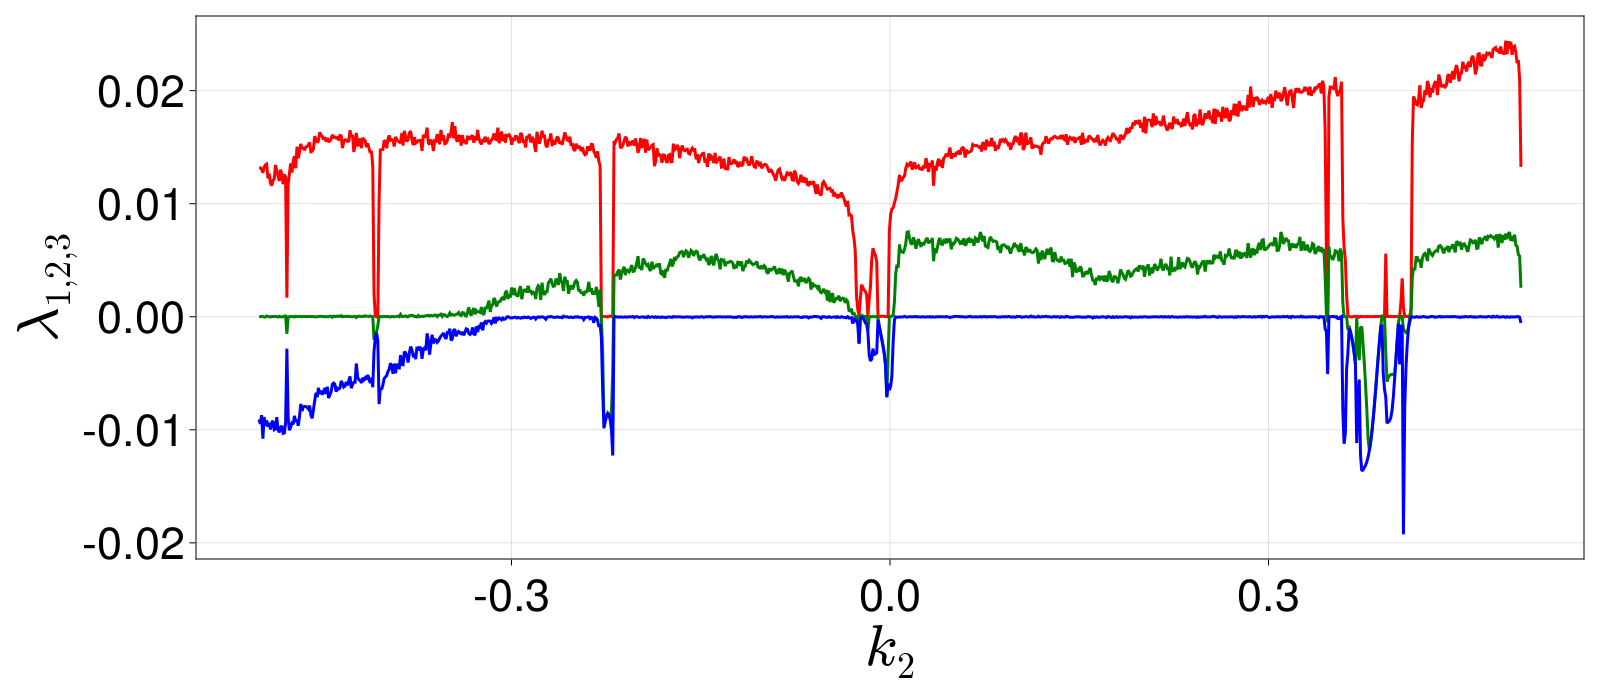

In [11]:
ticks = range(-0.5, 0.5, length = 6)
yticks = range(-0.04, 0.02, length = 4)

f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k_{2}", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45)


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.0, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.0, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.0, color = "blue")

f